# Predicting Customer Satisfaction Using Sentiment Analysis

##Sentiment Analysis using Pretrained LLM
### Data Understanding and preprocessing

In [8]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')


In [9]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
def load_and_explore_data(path):
    # Load data
    df = pd.read_csv(path)
    # Initial exploration
    print("Dataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    return df


In [11]:
path='/content/sentiment_data.csv'
# Lets check the data quality and perform the further Analysis

df = load_and_explore_data(path)

Dataset Shape: (13372, 3)

First few rows:
      Id                                             Review  Rating
0  40884  I have been having trouble with my broadband a...       5
1  29851  First chip did not work at all but the custome...       4
2  35708  Considering my mothers Christmas present was d...       1
3   9246  The gentleman who came was fine ,but I when I ...       3
4  16179  Well after emailing on the 30 Sept and sending...       4

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13372 entries, 0 to 13371
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      13372 non-null  int64 
 1   Review  13372 non-null  object
 2   Rating  13372 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 313.5+ KB
None

Missing Values:
Id        0
Review    0
Rating    0
dtype: int64


In [12]:
# Check for duplicates
df.duplicated().sum()

0

In [13]:
df.shape


(13372, 3)

In [14]:


def analyze_text_features(df):
    # Add text length
    df['text_length'] = df['Review'].str.len()
    df['word_count'] = df['Review'].str.split().str.len()

    # Plotting text length distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='text_length', bins=50)
    plt.title('Distribution of Review Length (characters)')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='word_count', bins=50)
    plt.title('Distribution of Word Count')
    plt.show()

    # Text length statistics by rating
    avg_word_count_by_rating = df.groupby('Rating')['word_count'].mean().round(2)
    print("\nAverage word count by rating:")
    print(avg_word_count_by_rating)

    # Plot average word count vs rating
    plt.figure(figsize=(8, 5))
    sns.barplot(x=avg_word_count_by_rating.index, y=avg_word_count_by_rating.values, palette="viridis")
    plt.title('Average Word Count by Rating')
    plt.xlabel('Rating')
    plt.ylabel('Average Word Count')
    plt.show()

    return df


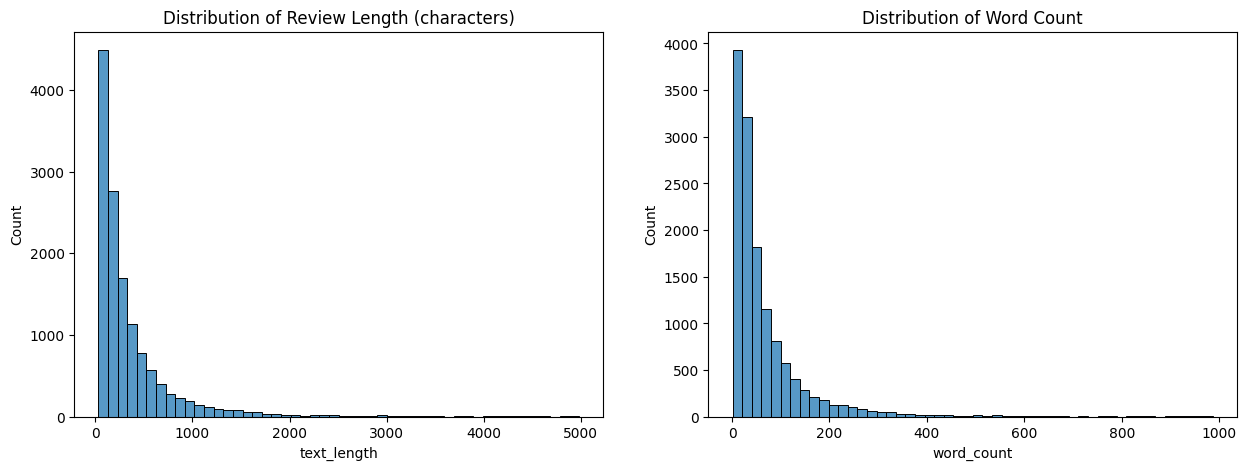


Average word count by rating:
Rating
1    114.41
2     87.24
3     66.20
4     43.83
5     26.53
Name: word_count, dtype: float64


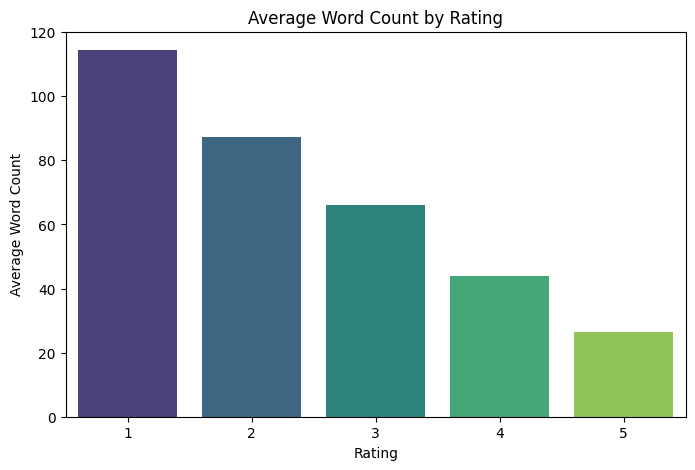

In [15]:
df = analyze_text_features(df)

## Lets perform Sentiment Analysis using RoBERTa Models

In [ ]:
# Import the important libraries
import torch
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

In [ ]:
# Check for the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Lets create a SentimentAnalyser Class
class SentimentAnalyzer:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.model = RobertaForSequenceClassification.from_pretrained('roberta-base').to(device)

    def get_sentiment(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            sentiment_score = probabilities[0][1].cpu().item()

        # Convert score to sentiment label
        if sentiment_score > 0.6:
            return 'positive', sentiment_score
        elif sentiment_score < 0.4:
            return 'negative', sentiment_score
        else:
            return 'neutral', sentiment_score

In [ ]:
sentiment_analyzer = SentimentAnalyzer()

In [49]:
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df['Sentiment'] = df['Rating'].apply(map_rating_to_sentiment)
print(df[['Review', 'Rating', 'Sentiment']].head())



                                              Review  Rating Sentiment
0  I have been having trouble with my broadband a...       5  positive
1  First chip did not work at all but the custome...       4  positive
2  Considering my mothers Christmas present was d...       1  negative
3  The gentleman who came was fine ,but I when I ...       3   neutral
4  Well after emailing on the 30 Sept and sending...       4  positive


In [ ]:
df_subset = df.head(1000)

In [ ]:
# Add a column for model-predicted sentiment
df_subset['Predicted_Sentiment'] = df_subset['Review'].apply(sentiment_analyzer.get_sentiment)

# Compare the two sentiments
df_subset['Sentiment_Match'] = df_subset['Sentiment'] == df_subset['Predicted_Sentiment']

# View mismatches
mismatches = df_subset[df_subset['Sentiment_Match'] == False]
print("Number of mismatches:", len(mismatches))
print(mismatches[['Review', 'Rating', 'Sentiment', 'Predicted_Sentiment']].head())



Number of mismatches: 1000
                                              Review  Rating Sentiment  \
0  Well the 4tb HDD arrived well packed and work ...       5  positive   
1  Easy to order, good options, good prices, good...       4  positive   
2  Item still not received due to Amazon delivery...       1  negative   
3  I requested for a refund of £66 and samir said...       3   neutral   
4         Good price for iPhone 7 works like a dream       4  positive   

              Predicted_Sentiment  
0  (neutral, 0.45123937726020813)  
1   (neutral, 0.4506869912147522)  
2   (neutral, 0.4518750309944153)  
3   (neutral, 0.4553748369216919)  
4   (neutral, 0.4547162652015686)  


In [ ]:
df_subset.head(100)

,Id,Review,Rating,text_length,word_count,Sentiment,Predicted_Sentiment,Sentiment_Match
0,8364,Well the 4tb HDD arrived well packed and work ...,5,264,57,positive,"(neutral, 0.45123937726020813)",False
1,46007,"Easy to order, good options, good prices, good...",4,793,136,positive,"(neutral, 0.4506869912147522)",False
2,46463,Item still not received due to Amazon delivery...,1,54,9,negative,"(neutral, 0.4518750309944153)",False
3,51821,I requested for a refund of £66 and samir said...,3,175,38,neutral,"(neutral, 0.4553748369216919)",False
4,25027,Good price for iPhone 7 works like a dream,4,42,9,positive,"(neutral, 0.4547162652015686)",False
...,...,...,...,...,...,...,...,...
95,11872,Great range of products at reasonable prices. ...,5,89,14,positive,"(neutral, 0.4459660053253174)",False
96,58165,I feel Bt are a generally a good company but t...,2,382,74,negative,"(neutral, 0.45673757791519165)",False
97,9724,"My son went live on March28th, broadband fine ...",4,1222,235,positive,"(neutral, 0.44975346326828003)",False
98,23934,I have just started using this app I may rewri...,4,77,15,positive,"(neutral, 0.45505210757255554)",False


The  Response from pretrained model is not upto the mark as per requirement .Lets finetune the model.

## Lets FineTune the Model

In [ ]:
df

,Id,Review,Rating,text_length,word_count,Sentiment
0,8364,Well the 4tb HDD arrived well packed and work ...,5,264,57,positive
1,46007,"Easy to order, good options, good prices, good...",4,793,136,positive
2,46463,Item still not received due to Amazon delivery...,1,54,9,negative
3,51821,I requested for a refund of £66 and samir said...,3,175,38,neutral
4,25027,Good price for iPhone 7 works like a dream,4,42,9,positive
...,...,...,...,...,...,...
13367,34122,I am a supplier who uses Bark for business lea...,1,1592,312,negative
13368,45614,"They did one thing wrong, they told me it was ...",4,115,22,positive
13369,25136,"The exact part I needed, new condition but exp...",4,74,13,positive
13370,54875,Ordered washing machine element.\nPart arrived...,5,172,30,positive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

In [ ]:
df['Review'] = df['Review'].str.lower()


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Review'], df['Sentiment'], test_size=0.1)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
# Tokenize data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

label_dict = {'positive': 0, 'neutral': 1, 'negative': 2}
train_labels = [label_dict[label] for label in train_labels]
val_labels = [label_dict[label] for label in val_labels]

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    report_to="none",
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Fine-tune the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.102600
20,1.084700
30,1.055700
40,1.049000
50,1.024400
60,0.956100
70,0.936100
80,0.875400
90,0.839600
100,0.794200


TrainOutput(global_step=2259, training_loss=0.3649040991197175, metrics={'train_runtime': 890.8507, 'train_samples_per_second': 40.522, 'train_steps_per_second': 2.536, 'total_flos': 2374532816640768.0, 'train_loss': 0.3649040991197175, 'epoch': 3.0})

In [ ]:
model.save_pretrained('./content/model/')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained('./content/tokenizer/')


('./content/tokenizer/tokenizer_config.json',
 './content/tokenizer/special_tokens_map.json',
 './content/tokenizer/vocab.txt',
 './content/tokenizer/added_tokens.json')

In [ ]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.6575331091880798, 'eval_runtime': 9.7112, 'eval_samples_per_second': 137.778, 'eval_steps_per_second': 17.3, 'epoch': 3.0}


In [55]:
# Move the tensor to the GPU
def prepare_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs


In [54]:
# From this fuction the response will return as 0,1,2 and 0 is positive,1 is nuetral and 2 negative
def predict(text):
    model.eval()
    with torch.no_grad():
        inputs = prepare_text(text)
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
    return predicted_class


In [ ]:
review_text = "The product is amazing and works perfectly!"
prediction = predict(review_text)
print(f"Predicted class for the review: {prediction}")


Predicted class for the review: 0


In [47]:
test_df=pd.read_csv('/content/Reviews_Dataset.csv')

In [52]:
test_df['Sentiment'] = test_df['Satisfaction Rating'].apply(map_rating_to_sentiment)
print(test_df[['Review Text', 'Satisfaction Rating', 'Sentiment']].head())

                                   Review Text  Satisfaction Rating Sentiment
0                     The best I've ever used!                    5  positive
1      Love the features but could be cheaper.                    4  positive
2      Poor craftsmanship, broke on first use.                    1  negative
3  Great service, I will definitely come back!                    5  positive
4      Love the features but could be cheaper.                    4  positive


In [ ]:
test_df['Predicted_Sentiment'] = test_df['Review Text'].apply(predict)

test_df['Sentiment_Match'] = test_df['Sentiment'] == test_df['Predicted_Sentiment']

# View mismatches
mismatches = test_df[test_df['Sentiment_Match'] == False]
print("Number of mismatches:", len(mismatches))
print(mismatches[['Review Text', 'Satisfaction Rating','Sentiment', 'Predicted_Sentiment']].head())


## Feature Extraction

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def batch_tokenize(texts, batch_size=10):
    for i in range(0, len(texts), batch_size):
        yield tokenizer(texts[i:i + batch_size], padding=True, truncation=True, max_length=512, return_tensors='pt')

def extract_embeddings(batch):
    inputs = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()


In [ ]:
texts = df['Review'].tolist()

In [ ]:
batch_size = 32  # Adjust batch size based on your system's capability and memory
embeddings = []

for index, batch in enumerate(batch_tokenize(texts, batch_size)):
    batch_embeddings = extract_embeddings(batch)
    embeddings.append(batch_embeddings)
    if index % 10 == 0:
        print(f"Processed {index * batch_size}/{len(texts)} texts")

# Concatenate all batch embeddings into one numpy array
final_embeddings = np.vstack(embeddings)


Processed 0/13372 texts
Processed 320/13372 texts
Processed 640/13372 texts
Processed 960/13372 texts
Processed 1280/13372 texts
Processed 1600/13372 texts
Processed 1920/13372 texts
Processed 2240/13372 texts
Processed 2560/13372 texts
Processed 2880/13372 texts
Processed 3200/13372 texts
Processed 3520/13372 texts
Processed 3840/13372 texts
Processed 4160/13372 texts
Processed 4480/13372 texts
Processed 4800/13372 texts
Processed 5120/13372 texts
Processed 5440/13372 texts
Processed 5760/13372 texts
Processed 6080/13372 texts
Processed 6400/13372 texts
Processed 6720/13372 texts
Processed 7040/13372 texts
Processed 7360/13372 texts
Processed 7680/13372 texts
Processed 8000/13372 texts
Processed 8320/13372 texts
Processed 8640/13372 texts
Processed 8960/13372 texts
Processed 9280/13372 texts
Processed 9600/13372 texts
Processed 9920/13372 texts
Processed 10240/13372 texts
Processed 10560/13372 texts
Processed 10880/13372 texts
Processed 11200/13372 texts
Processed 11520/13372 texts
Pr

In [ ]:
# Saving the embeddings
np.save('text_embeddings.npy', final_embeddings)

df['embeddings'] = list(final_embeddings)

In [16]:
embeddings = np.load('/content/text_embeddings.npy')


In [17]:
embeddings

array([[ 0.15570626,  0.01375184,  0.321816  , ...,  0.11334125,
         0.01347976, -0.18358134],
       [ 0.1689545 , -0.27458727,  0.48468843, ...,  0.01100035,
         0.17666677, -0.13455194],
       [-0.20689356, -0.05663066,  0.24687858, ...,  0.07400143,
         0.12308495,  0.05447633],
       ...,
       [ 0.15936258, -0.06947536,  0.33537084, ...,  0.01989541,
         0.02931305,  0.22863734],
       [ 0.22119978, -0.14265086,  0.48567685, ...,  0.17683703,
        -0.09109732, -0.12102522],
       [ 0.0551529 , -0.33520892,  0.2700706 , ...,  0.04989337,
        -0.02056443, -0.04020666]], dtype=float32)

In [19]:
df['embeddings'] = list(embeddings)
df

,Id,Review,Rating,text_length,word_count,embeddings
0,40884,I have been having trouble with my broadband a...,5,208,40,"[0.15570626, 0.013751839, 0.321816, -0.0847375..."
1,29851,First chip did not work at all but the custome...,4,126,22,"[0.1689545, -0.27458727, 0.48468843, 0.2344490..."
2,35708,Considering my mothers Christmas present was d...,1,172,29,"[-0.20689356, -0.05663066, 0.24687858, -0.0028..."
3,9246,"The gentleman who came was fine ,but I when I ...",3,1090,219,"[-0.13260491, -0.01072179, 0.29784346, -0.2787..."
4,16179,Well after emailing on the 30 Sept and sending...,4,760,141,"[-0.03525299, 0.021033151, 0.51778775, -0.0972..."
...,...,...,...,...,...,...
13367,25602,Reported fault with 2 yr old hoover washing ma...,1,1759,311,"[-0.08317629, -0.068063006, 0.41591945, -0.090..."
13368,52449,Delivery was organised for Friday but did not ...,4,180,36,"[0.07720025, -0.29406205, 0.4227364, -0.068079..."
13369,45748,Took out a phone contract and traded in my old...,4,1170,221,"[0.15936258, -0.06947536, 0.33537084, -0.11462..."
13370,39808,Amidst the chaos of Christmas deliveries my GH...,5,259,46,"[0.22119978, -0.14265086, 0.48567685, -0.11795..."


# Model Building


### Required Preprocessing

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [21]:
df

,Id,Review,Rating,text_length,word_count,embeddings
0,40884,I have been having trouble with my broadband a...,5,208,40,"[0.15570626, 0.013751839, 0.321816, -0.0847375..."
1,29851,First chip did not work at all but the custome...,4,126,22,"[0.1689545, -0.27458727, 0.48468843, 0.2344490..."
2,35708,Considering my mothers Christmas present was d...,1,172,29,"[-0.20689356, -0.05663066, 0.24687858, -0.0028..."
3,9246,"The gentleman who came was fine ,but I when I ...",3,1090,219,"[-0.13260491, -0.01072179, 0.29784346, -0.2787..."
4,16179,Well after emailing on the 30 Sept and sending...,4,760,141,"[-0.03525299, 0.021033151, 0.51778775, -0.0972..."
...,...,...,...,...,...,...
13367,25602,Reported fault with 2 yr old hoover washing ma...,1,1759,311,"[-0.08317629, -0.068063006, 0.41591945, -0.090..."
13368,52449,Delivery was organised for Friday but did not ...,4,180,36,"[0.07720025, -0.29406205, 0.4227364, -0.068079..."
13369,45748,Took out a phone contract and traded in my old...,4,1170,221,"[0.15936258, -0.06947536, 0.33537084, -0.11462..."
13370,39808,Amidst the chaos of Christmas deliveries my GH...,5,259,46,"[0.22119978, -0.14265086, 0.48567685, -0.11795..."


In [22]:
print("Correlation between word_count and text_length:", df['word_count'].corr(df['text_length']))


Correlation between word_count and text_length: 0.9980065789516142


In [23]:
## Since correlation is very high lets use one of it.

In [24]:
embeddings = np.load('text_embeddings.npy')


In [25]:
Word_count_features = df[['word_count']].values

In [26]:
# Scale features (important for many models)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(Word_count_features)

# Combine scaled features with embeddings
combined_features = np.hstack([embeddings, scaled_features])

In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['Rating'], test_size=0.2, random_state=42)


### Model Training

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(n_estimators=50, learning_rate=0.2)
gradient_boosting.fit(X_train, y_train)
y_pred_gb = gradient_boosting.predict(X_test)



## Model Evaluation

In [33]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
# Printing out the classification reports for each model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.82      0.76       620
           2       0.36      0.29      0.32       337
           3       0.34      0.26      0.29       351
           4       0.52      0.55      0.54       683
           5       0.74      0.75      0.74       684

    accuracy                           0.59      2675
   macro avg       0.53      0.53      0.53      2675
weighted avg       0.58      0.59      0.58      2675

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.87      0.70       620
           2       0.32      0.06      0.10       337
           3       0.20      0.05      0.07       351
           4       0.44      0.56      0.49       683
           5       0.69      0.75      0.72       684

    accuracy                           0.55      2675
   macro avg       0.45      0.46      0.42      26

In [34]:
# Logistic Regression Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr', average='macro'))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\n" + "-"*60 + "\n")

# Random Forest Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(
    y_test,
    random_forest.predict_proba(X_test),
    multi_class='ovr',
    average='macro'
))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

print("\n" + "-"*60 + "\n")

# Gradient Boosting Evaluation
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting ROC-AUC:",  roc_auc_score(
    y_test,
    gradient_boosting.predict_proba(X_test),
    multi_class='ovr',
    average='macro'
))
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

print("\n" + "-"*60 + "\n")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.82      0.76       620
           2       0.36      0.29      0.32       337
           3       0.34      0.26      0.29       351
           4       0.52      0.55      0.54       683
           5       0.74      0.75      0.74       684

    accuracy                           0.59      2675
   macro avg       0.53      0.53      0.53      2675
weighted avg       0.58      0.59      0.58      2675

Logistic Regression Accuracy: 0.5940186915887851
Logistic Regression ROC-AUC: 0.8588417130213781
Logistic Regression Confusion Matrix:
 [[511  65  28  13   3]
 [110  97  70  51   9]
 [ 62  75  91 119   4]
 [ 31  35  74 376 167]
 [  4   0   7 159 514]]

------------------------------------------------------------

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.87      0.70       620
       

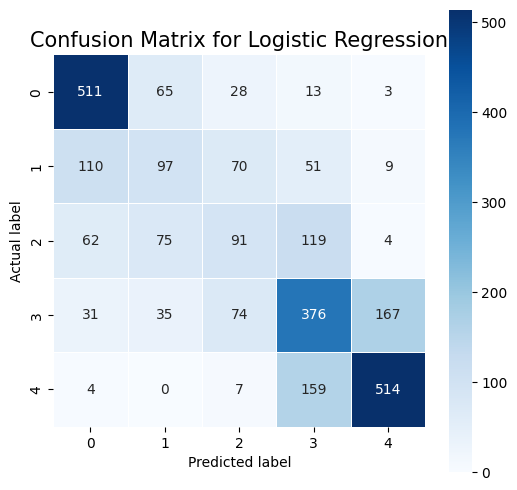

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title, size = 15)
    plt.show()

plot_confusion_matrix(confusion_matrix(y_test, y_pred_lr), "Confusion Matrix for Logistic Regression")


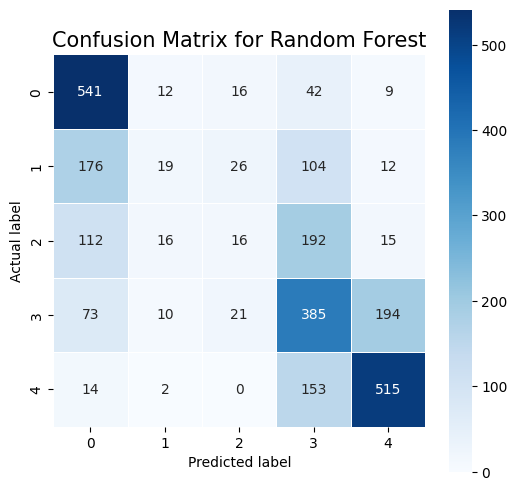

In [36]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf), "Confusion Matrix for Random Forest")


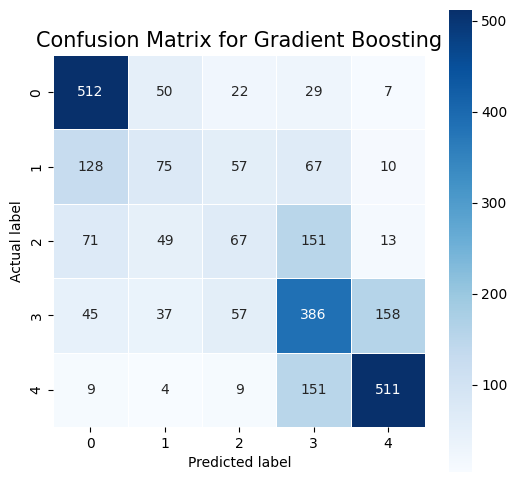

In [37]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_gb), "Confusion Matrix for Gradient Boosting")


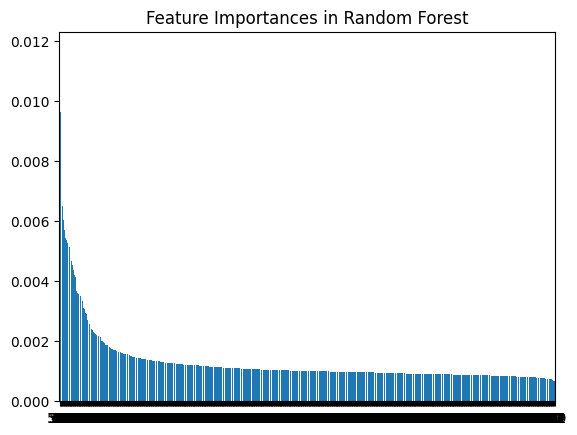

In [38]:
# Example for Random Forest
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances in Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [41]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}


grid_search_lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='roc_auc')
grid_search_lr.fit(X_train, y_train)

print("Best parameters:", grid_search_lr.best_params_)
print("Best cross-validated ROC-AUC:", grid_search_lr.best_score_)



Best parameters: {'C': 0.1, 'penalty': 'l1'}
Best cross-validated ROC-AUC: nan


In [42]:
# Lets retrain the model with best parameters
from sklearn.linear_model import LogisticRegression

final_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=10000)
final_model.fit(X_train, y_train)


LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear')

In [43]:
import joblib

# Save the model to disk
joblib.dump(final_model, 'final_logistic_regression_model.joblib')


['final_logistic_regression_model.joblib']

# END